In [1]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams["figure.figsize"] = (20, 20)

In [33]:
!wget https://github.com/dastratakos/Homography-Estimation/raw/main/examples/images/02/1.png
!wget https://github.com/dastratakos/Homography-Estimation/raw/main/examples/images/02/2.png

--2023-01-26 12:04:35--  https://github.com/dastratakos/Homography-Estimation/raw/main/examples/images/02/1.png
Resolving github.com (github.com)... 140.82.121.4
Connecting to github.com (github.com)|140.82.121.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dastratakos/Homography-Estimation/main/examples/images/02/1.png [following]
--2023-01-26 12:04:35--  https://raw.githubusercontent.com/dastratakos/Homography-Estimation/main/examples/images/02/1.png
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.110.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16225761 (15M) [application/octet-stream]
Saving to: ‘1.png.1’

1.png.1             100%[===================>]  15,47M  23,8MB/s    in 0,7s    

2023-01-26 12:04:36 (23,8 MB/s) - ‘1.png.1’ saved 

In [35]:
class Matcher:
    
    def __init__(self):
        self.det = cv2.SIFT_create()
        self.matcher = cv2.BFMatcher(cv2.NORM_L2, True)
        
    def __call__(self, img1, img2):
        kp1, desc1 = self.det.detectAndCompute(img1, None)
        kp2, desc2 = self.det.detectAndCompute(img2, None)
  
        matches = self.matcher.match(desc1, desc2)
        point_map = np.array([
            [kp1[match.queryIdx].pt[0],
             kp1[match.queryIdx].pt[1],
             kp2[match.trainIdx].pt[0],
             kp2[match.trainIdx].pt[1]] for match in matches
        ])

        return point_map
    
    @staticmethod
    def draw_keypoints(img, points):
        img_to_draw = np.dstack([img, img, img])
        
        for p in points:
            point = (int(p[0]), int(p[1]))
            cv2.circle(img_to_draw, point, 5, (255, 0, 0), 1)
            
        return img_to_draw
    
m = Matcher()

In [27]:
img1 = cv2.imread('1.png', 0)
img2 = cv2.imread('2.png', 0)

img1 = cv2.resize(img1, (0, 0), fx=0.25, fy=0.25)
img2 = cv2.resize(img2, (0, 0), fx=0.25, fy=0.25)

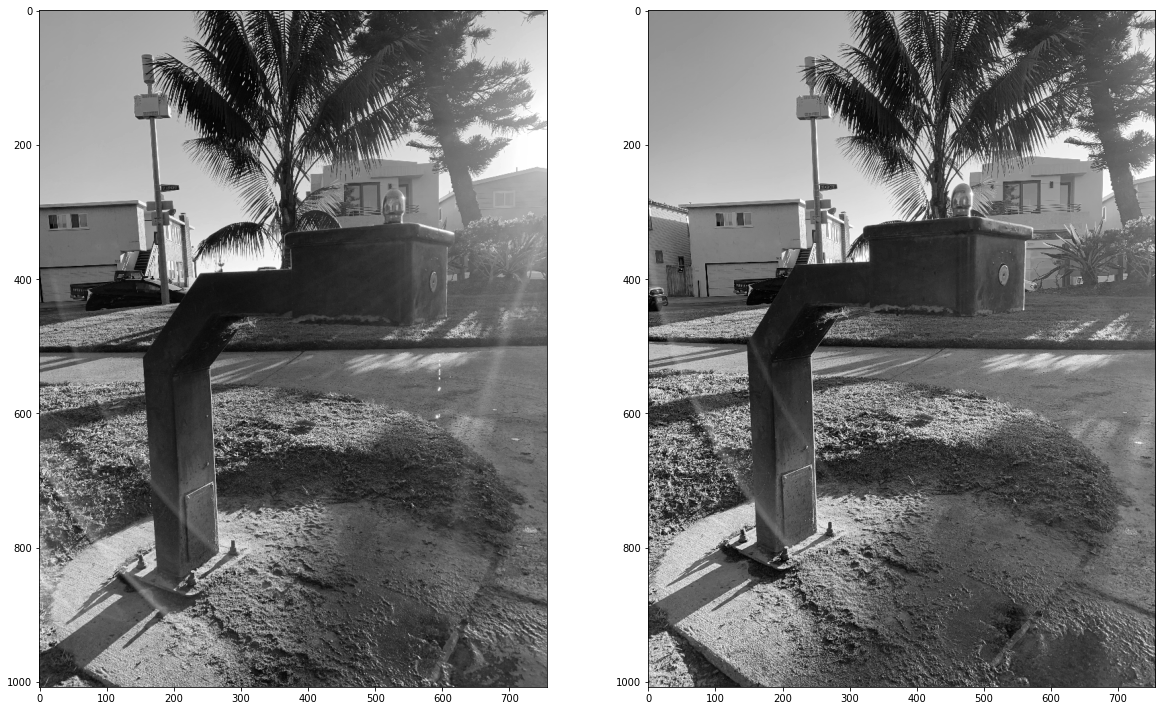

In [30]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(img1, cmap="gray")
ax[1].imshow(img2, cmap="gray")
plt.show()

In [29]:
pt_map = m(img1, img2)
pt_map.shape

(1955, 4)

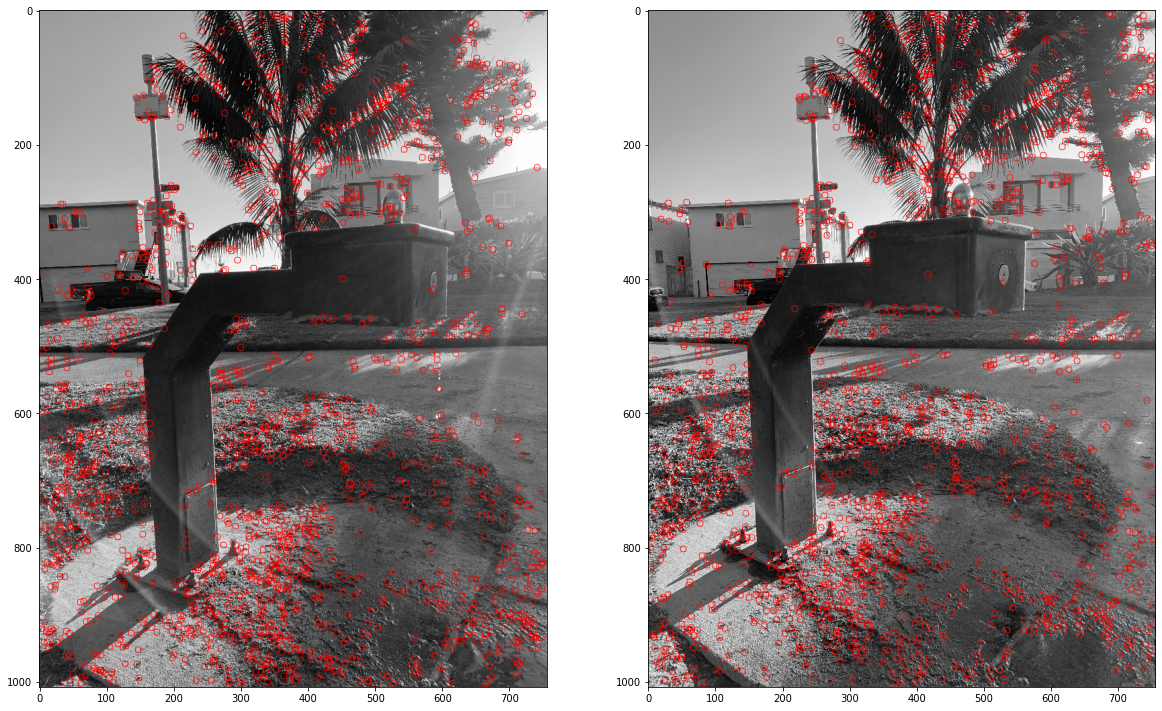

In [36]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(Matcher.draw_keypoints(img1, pt_map[:, :2]))
ax[1].imshow(Matcher.draw_keypoints(img2, pt_map[:, 2:]))
plt.show()

In [ ]:
def ransac(point_map, threshold=THRESHOLD):
    bestInliers = set()
    homography = None
    
    for i in range(NUM_ITERS):
        # randomly choose 4 points from the matrix to compute the homography
        pairs = [point_map[i] for i in np.random.choice(len(point_map), 4)]

        H = computeHomography(pairs)
        inliers = {(c[0], c[1], c[2], c[3])
                   for c in point_map if dist(c, H) < 500}

        if verbose:
            print(f'\x1b[2K\r└──> iteration {i + 1}/{NUM_ITERS} ' +
                  f'\t{len(inliers)} inlier' + ('s ' if len(inliers) != 1 else ' ') +
                  f'\tbest: {len(bestInliers)}', end='')

        if len(inliers) > len(bestInliers):
            bestInliers = inliers
            homography = H
            if len(bestInliers) > (len(point_map) * threshold):
                break

    if verbose:
        print(f'\nNum matches: {len(point_map)}')
        print(f'Num inliers: {len(bestInliers)}')
        print(f'Min inliers: {len(point_map) * threshold}')

    return homography, bestInliers

In [138]:
def chom(pm: np.ndarray) -> np.ndarray:
    A = np.zeros((pm.shape[0] * 2, 9))
    
    
    fr = np.stack([
        pm[:, 0], pm[:, 1], np.ones(pm.shape[0]),
        np.zeros(pm.shape[0]), np.zeros(pm.shape[0]),
        np.zeros(pm.shape[0]), -pm[:, 2] * pm[:, 0],
        -pm[:, 2] * pm[:, 1], -pm[:, 2]
    ], axis=1)
   
    sr = np.stack([
        np.zeros(pm.shape[0]), np.zeros(pm.shape[0]),
        np.zeros(pm.shape[0]), pm[:, 0], pm[:, 1],
        np.ones(pm.shape[0]), -pm[:, 3] * pm[:, 0],
        -pm[:, 3] * pm[:, 1], -pm[:, 3]
    ], axis=1)
    
    # print(fr.shape, sr.shape)
    
    A[::2, :] = fr
    A[1::2, :] = sr
    
    # print(A.shape)
    # print(fr[:2], sr[:2], A[:4], sep='\n\n')

    
    # for x1, y1, x2, y2 in pairs:
    #     A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
    #     A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1 / H.item(8)) * H
    
    return H


def chom2(pm: np.ndarray, h7: float = None, h8: float = None) -> np.ndarray:
    A = np.zeros((pm.shape[0] * 2, 9))
    
    
    fr = np.stack([
        pm[:, 0], pm[:, 1], np.ones(pm.shape[0]),
        np.zeros(pm.shape[0]), np.zeros(pm.shape[0]),
        np.zeros(pm.shape[0]), -pm[:, 2] * pm[:, 0],
        -pm[:, 2] * pm[:, 1], -pm[:, 2]
    ], axis=1)
   
    sr = np.stack([
        np.zeros(pm.shape[0]), np.zeros(pm.shape[0]),
        np.zeros(pm.shape[0]), pm[:, 0], pm[:, 1],
        np.ones(pm.shape[0]), -pm[:, 3] * pm[:, 0],
        -pm[:, 3] * pm[:, 1], -pm[:, 3]
    ], axis=1)
    
    # print(fr.shape, sr.shape)
    
    A[::2, :] = fr
    A[1::2, :] = sr
    
    # print(A.shape)
    # print(fr[:2], sr[:2], A[:4], sep='\n\n')

    
    # for x1, y1, x2, y2 in pairs:
    #     A.append([x1, y1, 1, 0, 0, 0, -x2 * x1, -x2 * y1, -x2])
    #     A.append([0, 0, 0, x1, y1, 1, -y2 * x1, -y2 * y1, -y2])

    U, S, V = np.linalg.svd(A)
    H = np.reshape(V[-1], (3, 3))
    H = (1 / H.item(8)) * H
    
    return H

In [136]:
H1 = chom(pt_map[:4, :])
H1

array([[-5.26830649e-01, -1.08437570e+00,  4.21153156e+02],
       [-5.06642440e+02,  1.95769725e+00,  5.78263933e+02],
       [-3.58697885e-01, -1.39652797e-04,  1.00000000e+00]])

In [141]:
# num, Rs, Ts, Ns  = cv2.decomposeHomographyMat(H1, K)

In [139]:
chom2(pt_map[:3, :])

array([[ 0.0019362 , -0.00103617,  0.3959966 ],
       [-0.79872128,  0.0052103 ,  0.08943214],
       [ 0.72473234, -0.00752057,  1.        ]])

In [130]:
H2, inliers = cv2.findHomography(
    pt_map[:, :2], 
    pt_map[:, 2:]
)

In [131]:
H1, H2

(array([[-5.71430568e-01, -4.27887513e-01,  4.83611751e+02],
        [-9.43053726e-01, -4.60877351e-01,  6.33694352e+02],
        [-1.25970207e-03, -7.83132171e-04,  1.00000000e+00]]),
 array([[ 7.53620691e-01, -9.00408068e-02,  2.14005367e+02],
        [ 1.54957940e-01,  8.07590448e-01,  1.17796002e+02],
        [ 2.94461118e-04,  6.55551783e-05,  1.00000000e+00]]))

In [134]:
im_out = cv2.warpPerspective(img1, H1, (img2.shape[1], img2.shape[0]))

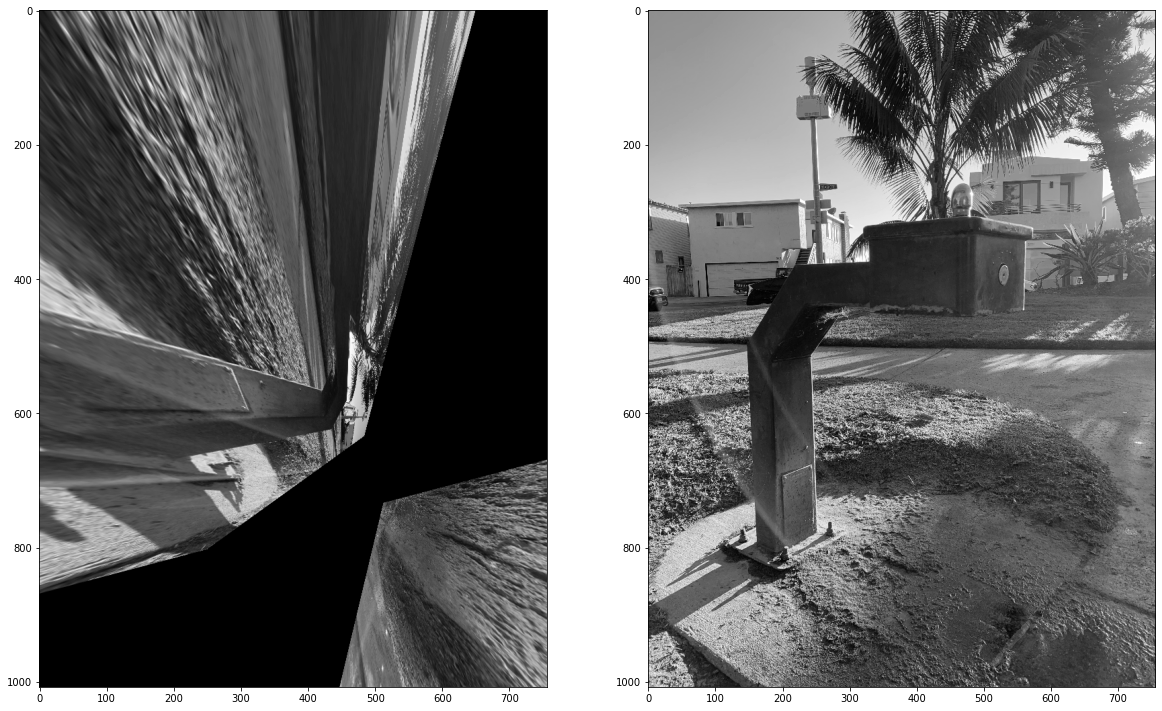

In [135]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(im_out, cmap="gray")
ax[1].imshow(img2, cmap="gray")
plt.show()